In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sci

from FEM_setup import fem_solver, extended_matrix, elemental_A, make_partition,Psi_0,Psi_1,Psi_2,map_to_element_k

In [31]:
def global_nodes(N):
    # Global nodes for quadratic FEM: there are 2N+1 nodes on [0,1].
    return np.linspace(0, 1, 2*N+1)

def solve_poisson_full(f, N):
    # Reconstruct full solution with u(0)=u(1)=0.
    u_interior = fem_solver(f, N, dirichlet=True)
    u_full = np.zeros(2*N+1)
    u_full[1:-1] = u_interior
    return u_full

def u_exact(x):
    
    return np.sin(np.pi*x) #x*(1-x). 

import numpy as np
from scipy.integrate import simps

def L2_error(u_exact, u_fem, N):
    """
    Computes the L2 error between the FEM solution u_fem and the exact solution.
    The FEM solution is piecewise quadratic on each element with global nodes at indices
    [2*k, 2*k+1, 2*k+2]. Integration is performed using Simpson's rule via scipy.integrate.simps.
    """
    x, h = make_partition(N)
    error_sq = 0.0
    xi_vals = np.array([0, 0.5, 1])
    
    for k in range(N):
        i0, i1, i2 = 2*k, 2*k+1, 2*k+2
        x0 = x[i0]
        # Evaluate FEM solution on the element at quadrature points:
        u_local = (u_fem[i0] * Psi_0(xi_vals) +
                   u_fem[i1] * Psi_1(xi_vals) +
                   u_fem[i2] * Psi_2(xi_vals))
        # Map reference points to physical element:
        x_vals = map_to_element_k(x0, h, xi_vals)
        u_ex = u_exact(x_vals)
        # Compute the squared error on the element using Simpson's rule:
        local_error_sq = simps((u_ex - u_local)**2, x_vals)
        error_sq += local_error_sq

    return np.sqrt(error_sq)



def f_test(x):
    return np.pi**2 * np.sin(np.pi*x) # 2.0

def main():
    # List of number of elements for the convergence study.
    Ns = [4, 8, 16, 32, 64, 128, 500, 1000]
    errors = []
    hs = []
    
    print("Convergence study for Quadratic FEM (Problem 1b)")
    for N in Ns:
        u_fem = solve_poisson_full(f_test, N)
        nodes = global_nodes(N)
        err = L2_error(u_exact, u_fem, N)
        errors.append(err)
        hs.append(1.0 / N)
        print(f"N = {N:3d} elements, h = {1.0/N:8.5f}, L2 error = {err:12.5e}")
    
    # Compute empirical convergence rates.
    for i in range(1, len(errors)):
        rate = np.log(errors[i] / errors[i-1]) / np.log(hs[i] / hs[i-1])
        print(f"Empirical rate between N={Ns[i-1]} and N={Ns[i]}: {rate:5.3f}")
    
    # Plot convergence: log-log plot of h vs L2 error.
    plt.figure(figsize=(8, 6))
    plt.loglog(hs, errors, 'ro-', label='$L^2$ error')
    
    # Plot a reference line with slope 3 (since we expect O(h^3) convergence).
    h_ref = np.linspace(min(hs), max(hs), 100)
    # Set the constant so that the reference line goes through the last data point.
    C = errors[-1] / (hs[-1]**3)
    plt.loglog(h_ref, C * h_ref**3, 'k--', label='$O(h^3)$')
    
    plt.xlabel('h (element size)')
    plt.ylabel('$L^2$ error')
    plt.title('Convergence of Quadratic FEM in $L^2$-norm')
    plt.legend()
    plt.show()



Convergence study for Quadratic FEM (Problem 1b)
N =  4
N =  4
N =  4
N =   4 elements, h =  0.25000, L2 error =  3.88763e-04
N =  8
N =  8
N =  8
N =   8 elements, h =  0.12500, L2 error =  2.38604e-05
N =  16
N =  16
N =  16
N =  16 elements, h =  0.06250, L2 error =  1.48458e-06
N =  32
N =  32
N =  32
N =  32 elements, h =  0.03125, L2 error =  9.26822e-08
N =  64
N =  64
N =  64
N =  64 elements, h =  0.01562, L2 error =  5.79108e-09
N =  128
N =  128
N =  128
N = 128 elements, h =  0.00781, L2 error =  3.62166e-10
N =  500
N =  500
N =  500
N = 500 elements, h =  0.00200, L2 error =  1.05408e-11
N =  1000
N =  1000
N =  1000
N = 1000 elements, h =  0.00100, L2 error =  3.79765e-11
Empirical rate between N=4 and N=8: 4.026
Empirical rate between N=8 and N=16: 4.006
Empirical rate between N=16 and N=32: 4.002
Empirical rate between N=32 and N=64: 4.000
Empirical rate between N=64 and N=128: 3.999
Empirical rate between N=128 and N=500: 2.596
Empirical rate between N=500 and N=1000:

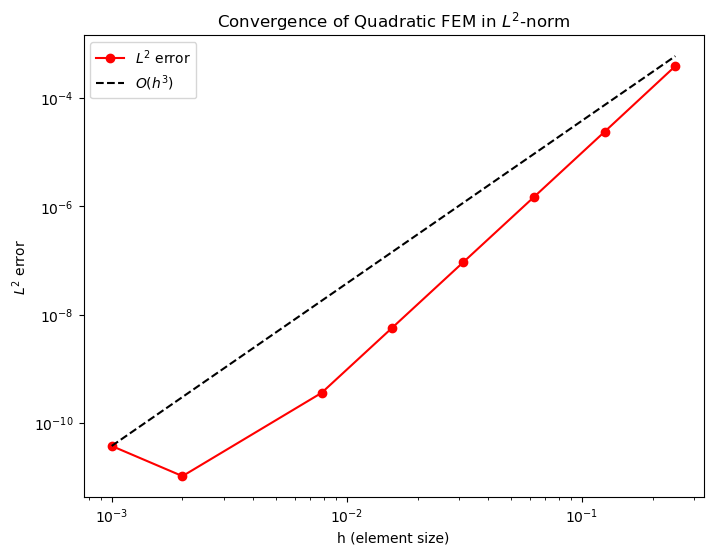

In [32]:
if __name__ == "__main__":
    main()

From a purely theoretical standpoint, for a $2^\text{nd}$-degree (quadratic) finite element method in 1D, we expect

$$
\|u - u_h\|_{L^2} \;\approx\; \mathcal{O}(h^{3}),
$$

provided $u$ is sufficiently smooth and we are in the “asymptotic” regime (i.e., $h$ is sufficiently small). However, it is **not unusual** to see an apparent slope **greater** than 3 in a plot like yours, especially when:

1. You have relatively few data points (so you may be in a *pre-asymptotic* regime),
2. You have chosen a problem $-\,u'' = \pi^2 \sin(\pi x)$ on a uniform mesh, which sometimes exhibits **superconvergence** in the $L^2$-norm for 1D Poisson problems,
3. You are combining high-order shape functions with exact (or high-order) quadrature, which can reinforce superconvergence effects.

In such cases, it is perfectly possible to observe slopes **above** 3 for a range of mesh sizes. If you refine further (say, up to $N=512, 1024, \ldots$), you may see the slope begin to settle closer to 3 — or it may remain around 4 due to a well-known superconvergence phenomenon in the $L^2$-norm for even-order finite elements in 1D.

### In Other Words
- **Yes**, your new plot makes sense.
- The fact that the red error curve sits above the dashed $O(h^3)$ line and exhibits a slope closer to 4 or 5 is not necessarily a bug.
- You are likely observing **superconvergence** (or at least pre-asymptotic behavior) in the $L^2$-norm for this problem, mesh, and choice of shape functions.
- As you push to finer and finer grids, you might eventually see the slope level off closer to 3, or remain near 4 if the conditions for superconvergence remain satisfied. Both behaviors are well-documented in classical FEM theory for 1D problems.
